In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import sys
import importlib
import ROOT as rt
import numpy as np
import numpy.ma as ma

from src import CMS_lumi, tdrstyle
from src.histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

from build_rdf import *

# importlib.reload(sys.modules['CMS_lumi'])
rt.ROOT.EnableImplicitMT()
tdr = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

rt.gStyle.SetOptFit(1011)
rt.gStyle.SetOptStat(0)

gc = []

date = 'feb6'
data_type = 'MC' # or 'Run3'

tree_name = 'MuonSystem'
if data_type == 'MC':
    fpath = 'data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'
else:
    fpath = 'data/raw/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'

lat = rt.TLatex()
lat.SetTextSize(0.04)
lat.SetTextAlign(11)


def my_define(rdf, out_col, in_col):
    if out_col in rdf.GetColumnNames():
        rdf = rdf.Redefine(out_col, in_col)
    else:
        rdf = rdf.Define(out_col, in_col)
    return rdf

def add_data_columns(rdf):
    rdf = my_define(rdf, 'nRechitClusters', 'nCscRechitClusters + nDtRechitClusters')
    for v in ('z', 'r'):
        for det in ('cscRechitCluster_match_gLLP_decay', 'dtRechitCluster_match_gLLP_decay', 'gLLP_decay_vertex'):
            rdf = my_define(rdf, f'{det}_abs_{v}', f'abs({det}_{v})')
    return rdf

def apply_event_cuts(rdf):
    rdf = rdf.Filter('nLeptons == 0 && nJets == 0')
    rdf = add_data_columns(rdf)
    return rdf

def apply_cluster_cuts(rdf, n_clusters=0):
    rdf = apply_size_cut(rdf, col_type='csc')
    rdf = apply_time_cut(rdf, col_type='csc')
    rdf = apply_time_spread_cut(rdf, col_type='csc')

    rdf = apply_size_cut(rdf, col_type='dt')
    # rdf = apply_time_cut(rdf, col_type='dt') #! No time column in ntuple
    # rdf = apply_time_spread_cut(rdf, col_type='dt') #! No time column in ntuple

    rdf = apply_cbid_cut(rdf)
    rdf = apply_endcap_nrechit_cut(rdf)
    rdf = apply_barrel_nrechit_cut(rdf)

    rdf = add_data_columns(rdf).Filter(f'nRechitClusters > {n_clusters}')
    return rdf

def canvas(name='c', nrows=1, ncols=1, width=None, height=None, grid=True):
    if width is None: width = ncols * 1200
    if height is None: height = nrows * 800
    c = rt.TCanvas(name, name, width, height)
    c.Clear()
    c.Divide(ncols, nrows)
    if grid:
        for i in range(nrows*ncols):
            c.cd(i + 1).SetGrid()
    c.cd(1)
    c.Draw()
    return c


Welcome to JupyROOT 6.26/10


In [2]:
# rdf_dict = {
#     'all' : {
#         'met50' :
#     }
# }

rdf_all = rt.RDataFrame(tree_name, fpath)
rdf_all = add_data_columns(rdf_all).Filter('nRechitClusters > 0')

# Remove signal region
rdf_bkg = apply_size_cut(rdf_all, 50, 100, 'csc') 
rdf_bkg = apply_size_cut(rdf_bkg, 50, 100, 'dt')
rdf_bkg = add_data_columns(rdf_bkg).Filter('nRechitClusters > 0')

rdf_sig = apply_size_cut(rdf_all, 100, 100_000, 'csc')
rdf_sig = apply_size_cut(rdf_sig, 100, 100_000, 'dt')
rdf_sig = add_data_columns(rdf_sig).Filter('nRechitClusters > 0')

# Apply MET >  50 GeV Cut
rdf_all_met50 = rdf_all.Filter('met > 50')
rdf_bkg_met50 = rdf_bkg.Filter('met > 50')
rdf_sig_met50 = rdf_sig.Filter('met > 50')

# Apply MET > 200 GeV Cut
rdf_all_met200 = rdf_all.Filter('met > 200')
rdf_bkg_met200 = rdf_bkg.Filter('met > 200')
rdf_sig_met200 = rdf_sig.Filter('met > 200')

# Apply Event Level Cuts
rdf_all_e = apply_event_cuts(rdf_all)
rdf_bkg_e = apply_event_cuts(rdf_bkg)
rdf_sig_e = apply_event_cuts(rdf_sig)
rdf_all_met50_e = apply_event_cuts(rdf_all_met50)
rdf_bkg_met50_e = apply_event_cuts(rdf_bkg_met50)
rdf_sig_met50_e = apply_event_cuts(rdf_sig_met50)
rdf_all_met200_e = apply_event_cuts(rdf_all_met200)
rdf_bkg_met200_e = apply_event_cuts(rdf_bkg_met200)
rdf_sig_met200_e = apply_event_cuts(rdf_sig_met200)

# Apply Cluster Cuts
rdf_all_ec = apply_cluster_cuts(rdf_all_e)
rdf_bkg_ec = apply_cluster_cuts(rdf_bkg_e)
rdf_sig_ec = apply_cluster_cuts(rdf_sig_e)
rdf_all_met50_ec = apply_cluster_cuts(rdf_all_met50_e)
rdf_bkg_met50_ec = apply_cluster_cuts(rdf_bkg_met50_e)
rdf_sig_met50_ec = apply_cluster_cuts(rdf_sig_met50_e)
rdf_all_met200_ec = apply_cluster_cuts(rdf_all_met200_e)
rdf_bkg_met200_ec = apply_cluster_cuts(rdf_bkg_met200_e)
rdf_sig_met200_ec = apply_cluster_cuts(rdf_sig_met200_e)

# Match
rdf_all_m = apply_match_cut(rdf_all)
rdf_bkg_m = apply_match_cut(rdf_bkg)
rdf_sig_m = apply_match_cut(rdf_sig)
rdf_all_met50_m = apply_match_cut(rdf_all_met50)
rdf_bkg_met50_m = apply_match_cut(rdf_bkg_met50)
rdf_sig_met50_m = apply_match_cut(rdf_sig_met50)
rdf_all_met200_m = apply_match_cut(rdf_all_met200)
rdf_bkg_met200_m = apply_match_cut(rdf_bkg_met200)
rdf_sig_met200_m = apply_match_cut(rdf_sig_met200)
rdf_all_e_m = apply_match_cut(rdf_all_e)
rdf_bkg_e_m = apply_match_cut(rdf_bkg_e)
rdf_sig_e_m = apply_match_cut(rdf_sig_e)
rdf_all_met50_e_m = apply_match_cut(rdf_all_met50_e)
rdf_bkg_met50_e_m = apply_match_cut(rdf_bkg_met50_e)
rdf_sig_met50_e_m = apply_match_cut(rdf_sig_met50_e)
rdf_all_met200_e_m = apply_match_cut(rdf_all_met200_e)
rdf_bkg_met200_e_m = apply_match_cut(rdf_bkg_met200_e)
rdf_sig_met200_e_m = apply_match_cut(rdf_sig_met200_e)
rdf_all_ec_m = apply_match_cut(rdf_all_ec)
rdf_bkg_ec_m = apply_match_cut(rdf_bkg_ec)
rdf_sig_ec_m = apply_match_cut(rdf_sig_ec)
rdf_all_met50_ec_m = apply_match_cut(rdf_all_met50_ec)
rdf_bkg_met50_ec_m = apply_match_cut(rdf_bkg_met50_ec)
rdf_sig_met50_ec_m = apply_match_cut(rdf_sig_met50_ec)
rdf_all_met200_ec_m = apply_match_cut(rdf_all_met200_ec)
rdf_bkg_met200_ec_m = apply_match_cut(rdf_bkg_met200_ec)
rdf_sig_met200_ec_m = apply_match_cut(rdf_sig_met200_ec)

#####################

# rdf = rdf.Define('cscCluster0Size', 'cscRechitClusterSize[0]')
# rdf = rdf.Define('cscCluster1Size', 'cscRechitClusterSize[1]')
# rdf = rdf.Define('dtCluster0Size', 'dtRechitClusterSize[0]')
# rdf = rdf.Define('dtCluster1Size', 'dtRechitClusterSize[1]')

In [3]:
templates = {
    'met' : ('h',';Missing E_{t};count',100,0,800),
    'ctau' : ('h',';c#tau;count',100,0,10000),
    
    'Met_dPhi' : ('h',';#delta#phi(E_{t}^{miss},Cluster);count',100,-np.pi,np.pi),
    'cscRechitClusterMet_dPhi' : ('h',';#delta#phi(E_{t}^{miss},CSC);count',100,-np.pi,np.pi),
    'dtRechitClusterMet_dPhi' : ('h',';#delta#phi(E_{t}^{miss},DT);count',100,-np.pi,np.pi),
    
    'nRechitClusters' : ('h',';N Clusters;count',7,-0.5,6.5),
    'nCscRechitClusters' : ('h',';N CSC Clusters;count',7,-0.5,6.5),
    'nDtRechitClusters' : ('h',';N DT Clusters;count',7,-0.5,6.5),
    
    'cscRechitClusterNStation10' : ('h',';CSC NStation10;count',7,-0.5,6.5),
    'dtRechitClusterNStation10' : ('h',';DT NStation10;count',7,-0.5,6.5),
    'cscRechitClusterAvgStation10' : ('h',';CSC AvgStation10;count',7,-0.5,6.5),
    'dtRechitClusterAvgStation10' : ('h',';DT AvgStation10;count',7,-0.5,6.5),
    
    'Size' : ('h',';Cluster Size;count',100,0,300),
    'cscRechitClusterSize' : ('h',';CSC Cluster Size;count',100,0,300),
    'dtRechitClusterSize' : ('h',';DT Cluster Size;count',100,0,300),
    
    'Eta' : ('h',';#eta;count',100,-3,3),
    'cscRechitClusterEta' : ('h',';CSC #eta;count',100,-3,3),
    'dtRechitClusterEta' : ('h',';DT #eta;count',100,-3,3),
    
    'Phi' : ('h',';#phi;count',100,-np.pi,np.pi),
    'cscRechitClusterPhi' : ('h',';CSC #phi;count',100,-np.pi,np.pi),
    'dtRechitClusterPhi' : ('h',';DT #phi;count',100,-np.pi,np.pi),
}

In [4]:
# if data_type == 'MC':
#     rdfs = [rdf_all, rdf_sig, rdf_bkg, rdf_all_e, rdf_sig_e, rdf_bkg_e, rdf_all_ec, rdf_sig_ec, rdf_bkg_ec]
#     colors = [rt.kBlack, rt.kBlue, rt.kRed] * 3
#     styles = [rt.kSolid]*3 + [rt.kDashed]*3 + [rt.kDotted]*3
# else:
#     rdfs = [rdf_bkg, rdf_bkg_e, rdf_bkg_ec]
#     colors = [rt.kBlack, rt.kBlue, rt.kRed] * 3
#     styles = [rt.kSolid] * 3

# vals = [
#     ['met'],
#     ['ctau'],
#     ['Met_dPhi', 'cscRechitClusterMet_dPhi', 'dtRechitClusterMet_dPhi'],
#     ['nRechitClusters', 'nCscRechitClusters','nDtRechitClusters'],
#     [['cscRechitClusterNStation10','dtRechitClusterNStation10'],
#     ['cscRechitClusterAvgStation10','dtRechitClusterAvgStation10']],
#     [['Size', 'cscRechitClusterSize','dtRechitClusterSize'],
#     ['Eta', 'cscRechitClusterEta','dtRechitClusterEta'],
#     ['Phi', 'cscRechitClusterPhi','dtRechitClusterPhi']],
# ]

# for values in vals:
#     out_name = values[0]
#     if isinstance(out_name, list):
#         out_name = out_name[0]
#     if out_name[:16] == 'cscRechitCluster': out_name = out_name[16:]
#     if out_name[:15] == 'dtRechitCluster': out_name = out_name[15:]
    
#     values = np.array(values)
#     print(out_name, values.shape, *values.shape)
#     c = canvas('c', *values.shape)

#     for iv, val in enumerate(values.flatten()):
#         print(val)
#         c.cd(iv + 1)
#         for i, (rdf, color, style) in enumerate(zip(rdfs, colors, styles)):
#             template = (f'{val}_{iv}_{i}', *templates[val][1:])
#             template2 = (f'{val}_{iv}_{i}_temp', *templates[val][1:])
#             if val in rdf.GetColumnNames():
#                 hh = rdf.Histo1D(template,val)
#             else:
#                 hh = rdf.Histo1D(template,'cscRechitCluster'+val)
#                 hh.Add(rdf.Histo1D(template2,'dtRechitCluster'+val).GetPtr())

#             hh.SetLineColor(color)
#             hh.SetLineStyle(style)
#             hh.SetLineWidth(3)
#             hh.SetMinimum(0)
#             gc.append(hh)

#         ymax = max([h.GetMaximum() for h in gc[-i-1:]])
#         for hh in gc[-i-1:]:
#             hh.SetMaximum(ymax*1.03)
#             hh.Draw('same')

#     c.Print(f'reports/weekly/{date}/{data_type}_{out_name}.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file reports/weekly/feb6/MC_n_clusters_2D.png has been created


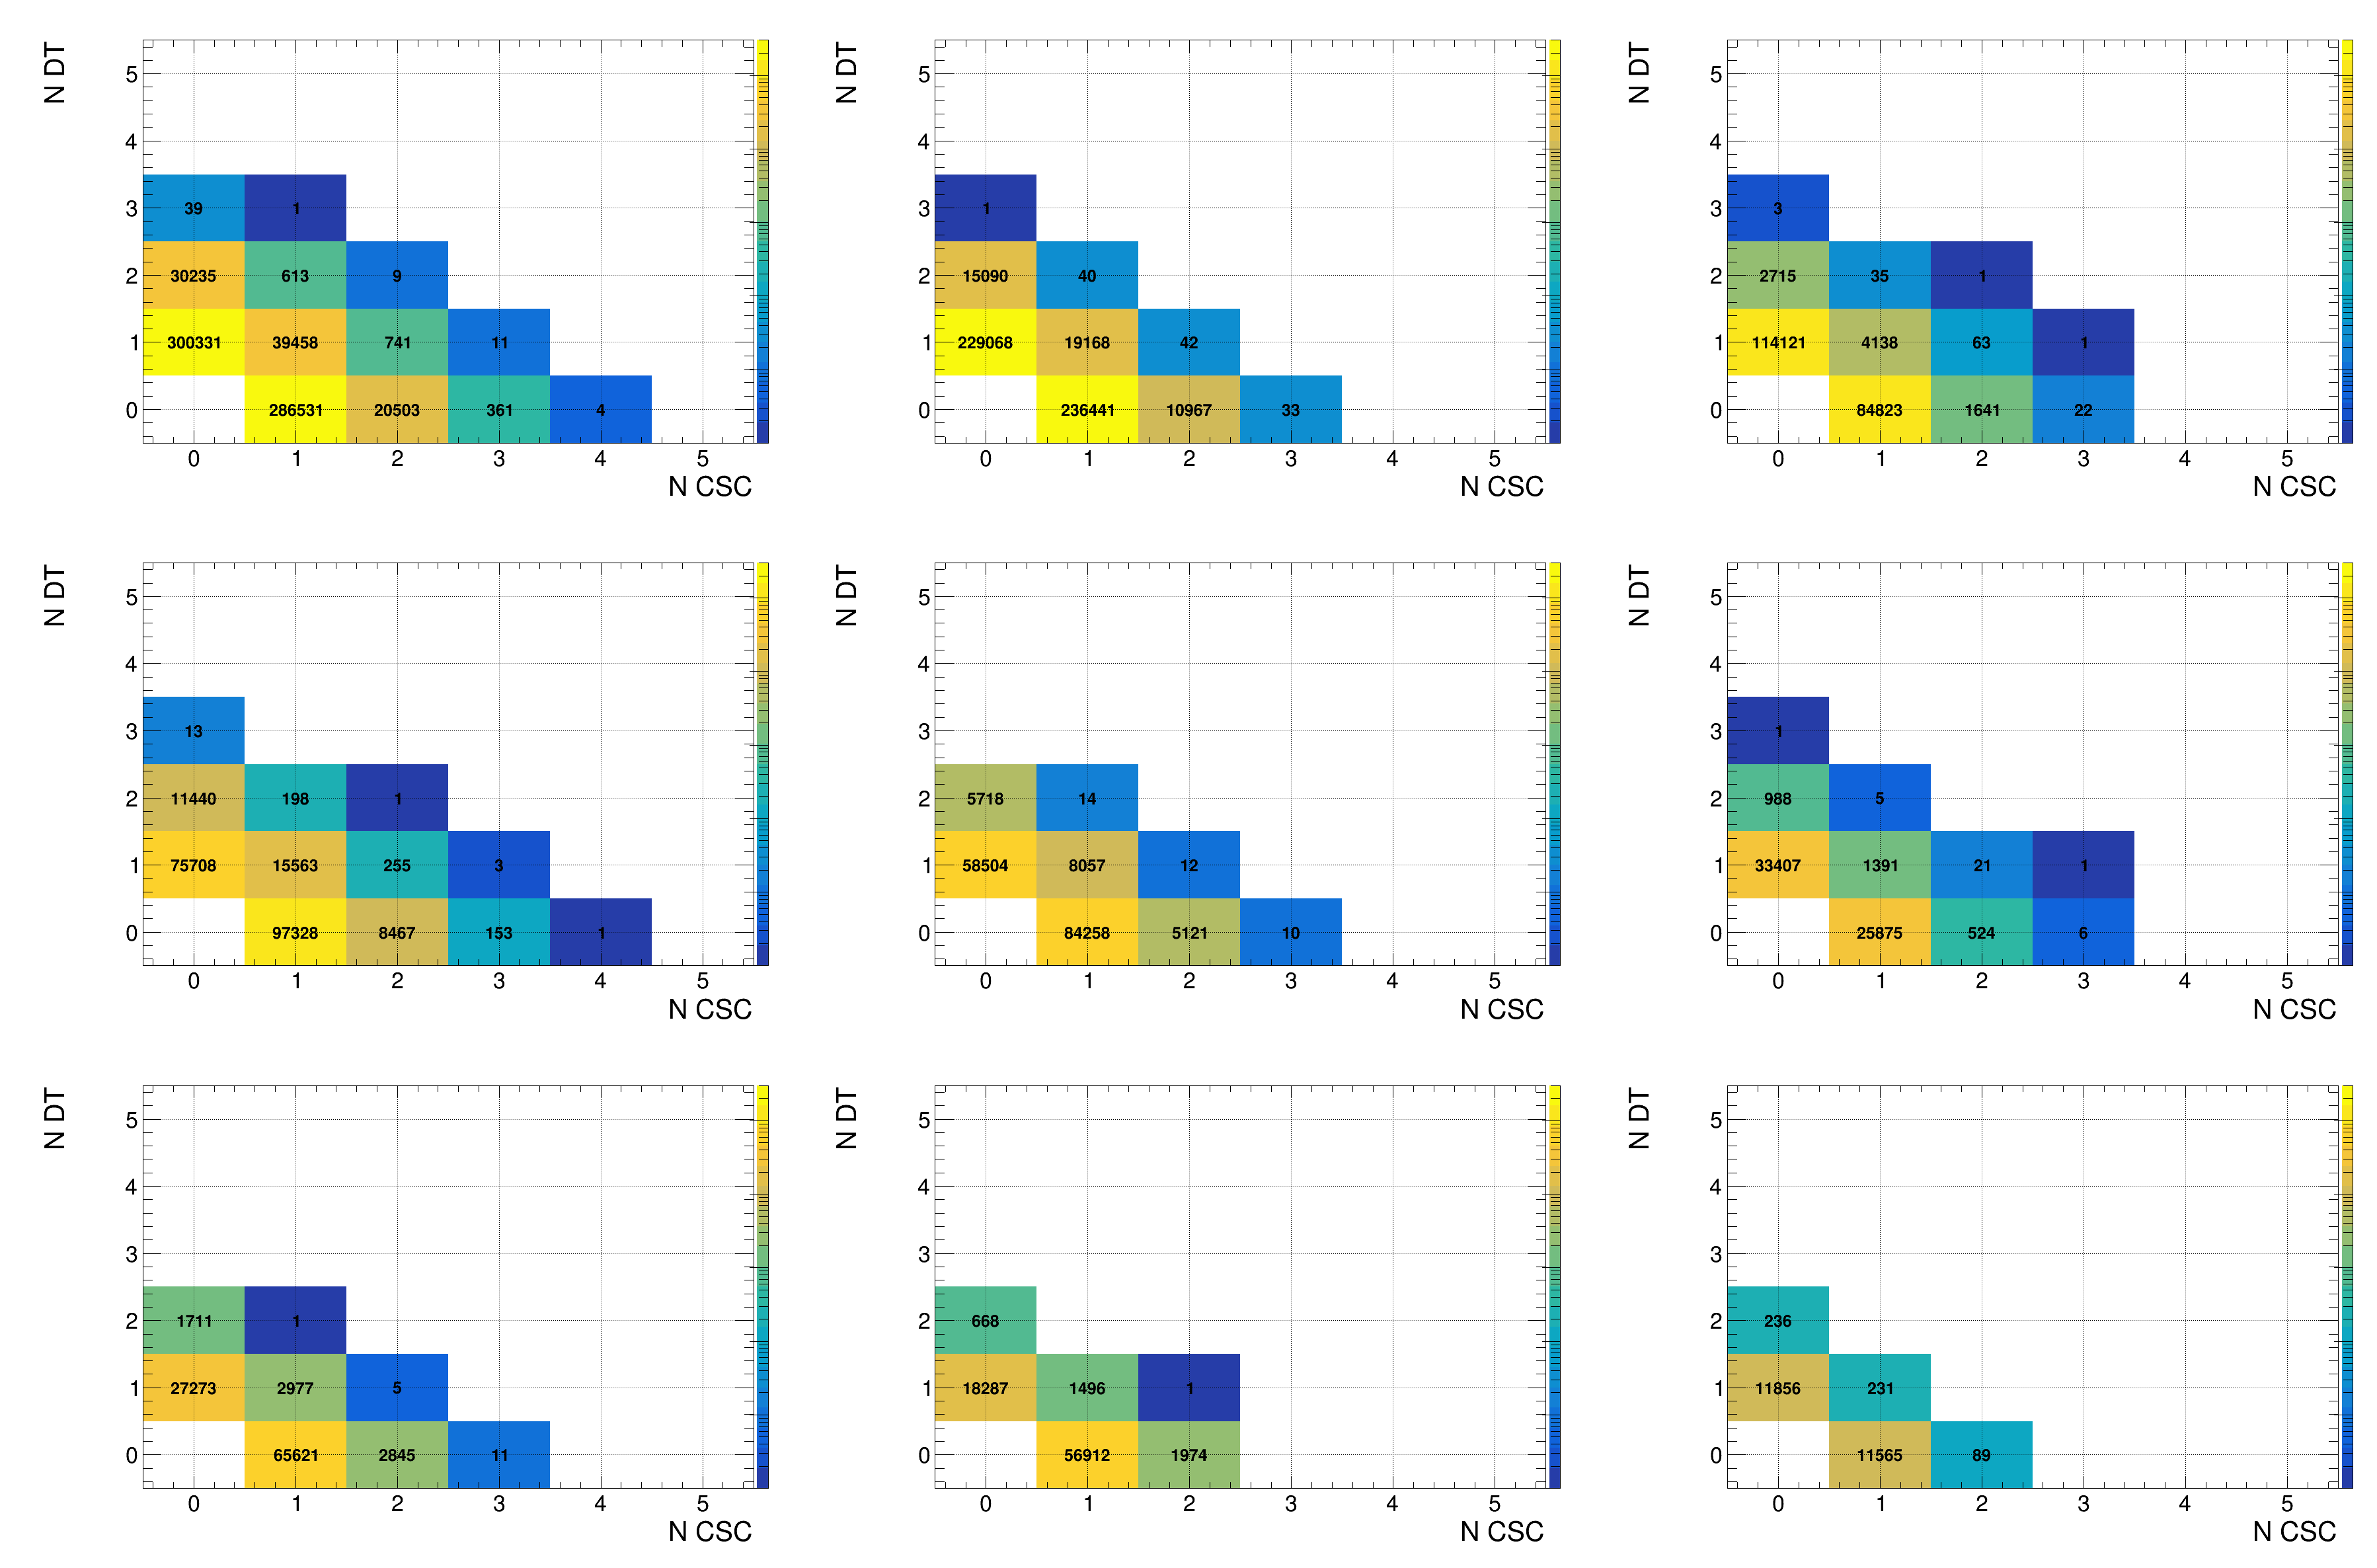

In [16]:
if data_type == 'MC':
    rdfs = [rdf_all, rdf_sig, rdf_bkg, rdf_all_e, rdf_sig_e, rdf_bkg_e, rdf_all_ec, rdf_sig_ec, rdf_bkg_ec]
    colors = [rt.kBlack, rt.kBlue, rt.kRed] * 3
    styles = [rt.kSolid]*3 + [rt.kDashed]*3 + [rt.kDotted]*3
else:
    rdfs = [rdf_bkg, rdf_bkg_e, rdf_bkg_ec]
    colors = [rt.kBlack, rt.kBlue, rt.kRed] * 3
    styles = [rt.kSolid] * 3

c = canvas('c', 3, 3)

bins2D = (6, -0.5, 5.5, 6, -0.5, 5.5)
ymax = 0
for i, rdf in enumerate(rdfs):
    hh = rdf.Histo2D(('h',';N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters')
    ymax = max(ymax, hh.GetMaximum())
    gc.append(hh)    
    
for i, hh in enumerate(gc[-i-1:]):
    c.cd(i + 1).SetGrid()
    c.cd(i + 1).SetLogz()
    hh.SetMaximum(ymax)
    hh.SetMarkerSize(1.8)
    hh.Draw('coltext')

c.Print(f'reports/weekly/{date}/{data_type}_n_clusters_2D.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


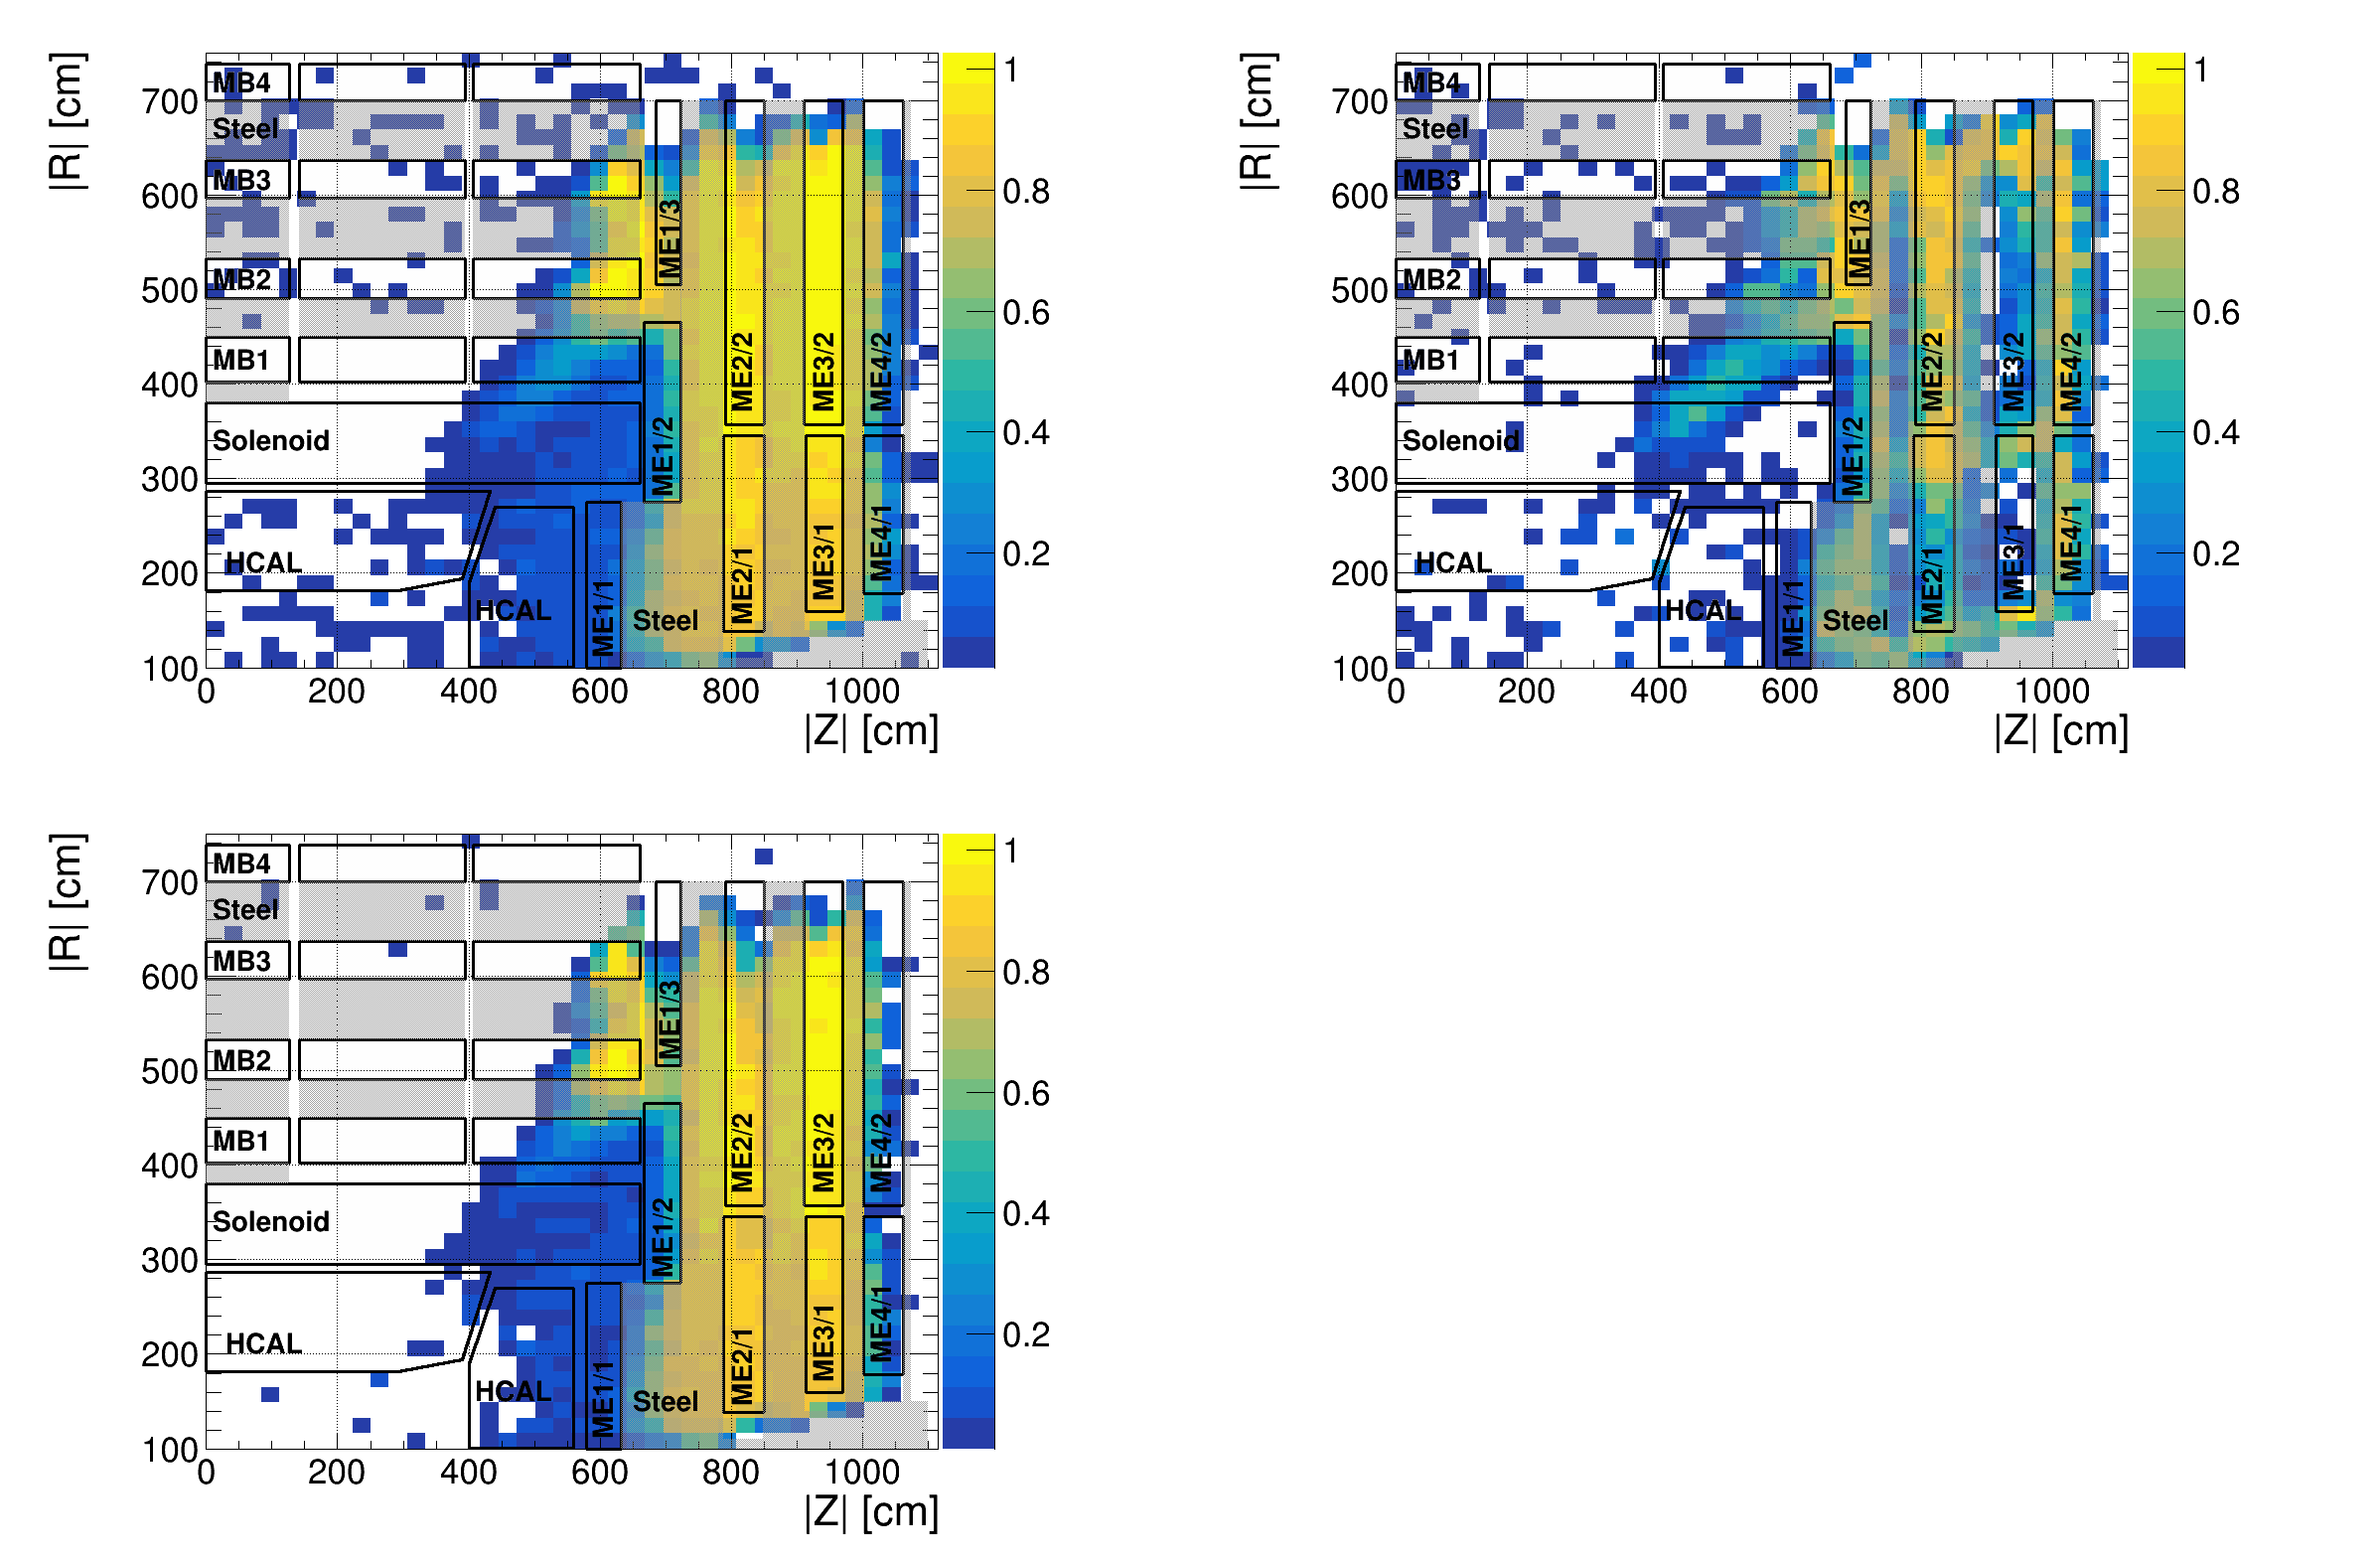

In [18]:
if data_type == 'MC':
    rdfs_num = [rdf_all_ec, rdf_bkg_ec, rdf_sig_ec]
    rdfs_den = [rdf_all_e_m, rdf_bkg_e_m, rdf_sig_e_m]

    c = canvas('c', 2, 2)

    vcut, vgen = 'RechitCluster_match_gLLP_decay_abs_', 'gLLP_decay_vertex_abs_'

    lat.SetTextAlign(33)

    bins = [40, 0, 15+1100, 40,100,750]#100-700

    model_zr = ('', '|R| vs |Z| Decay Efficiency;|Z| [cm];|R| [cm];Cluster Efficiency', *bins)
    ymax = 0
    for i, (rdfn, rdfd) in enumerate(zip(rdfs_num, rdfs_den)):
        rdfn = apply_vertex_cut(rdfn)
        hh_eff_n = rdfn.Histo2D(model_zr, 'csc' + vcut + 'z', 'csc' + vcut + 'r')
        # hh_eff_n.Add(rdfn.Histo2D(model_zr, 'dt' + vcut + 'z', 'dt' + vcut + 'r').GetPtr()) #! Breaks efficiency plots
        # hh_eff_n = rdfn.Histo2D(model_zr, 'dt' + vcut + 'z', 'dt' + vcut + 'r') #! Breaks efficiency plots
        hh_eff_d = rdfd.Histo2D(model_zr, vgen + 'z', vgen + 'r')

        hh_eff_n.Divide(hh_eff_d.GetPtr())
        hh_eff_n.SetMinimum(0.01)
        ymax = max(ymax, hh_eff_n.GetMaximum())
        # hh_eff_n.SetMaximum(1)
        gc.append(hh_eff_n)

    titles = ['All Events', 'Size < 100, "background"', '100 < Size, "signal"']
    for i, (hh, tt) in enumerate(zip(gc[-i-1:], titles)):
        c.cd(i + 1).SetGrid()
        c.cd(i + 1).SetRightMargin(0.2)
        hh.SetMaximum(ymax)
        hh.Draw('colz')
        boxes = []
        # DT
        boxes.append(rt.TBox(max(bins[1],-661),402,126.8,449)) #MB1, wheel0
        boxes.append(rt.TBox(141.8,402,395.4,449)) #MB1, wheel1
        boxes.append(rt.TBox(407.4,402,661,449)) #MB1, wheel2

        boxes.append(rt.TBox(max(bins[1],-661),490,126.8,533)) #MB2
        boxes.append(rt.TBox(141.8,490,395.4,533)) #MB2
        boxes.append(rt.TBox(407.4,490,661,533)) #MB2

        boxes.append(rt.TBox(max(bins[1],-661),597,126.8,636)) #MB3
        boxes.append(rt.TBox(141.8,597,395.4,636)) #MB3
        boxes.append(rt.TBox(407.4,597,661,636)) #MB3
        
        boxes.append(rt.TBox(max(bins[1],-661),700,126.8,738)) #MB4
        boxes.append(rt.TBox(141.8,700,395.4,738)) #MB4
        boxes.append(rt.TBox(407.4,700,661,738)) #MB4

        boxes.append(rt.TBox(max(bins[1],-661),295,661,380)) #solenoid

        # +z mirror of CSC
        boxes.append(rt.TBox(791,357,850,700)) #ME2/2
        boxes.append(rt.TBox(911,357,970,700)) #ME3/2
        boxes.append(rt.TBox(1002,357,1063,700)) #ME4/2

        boxes.append(rt.TBox(789,139,850,345)) #ME2/1
        boxes.append(rt.TBox(915,160,970,345)) #ME3/1
        boxes.append(rt.TBox(1002,178,1063,345)) #ME4/1

        boxes.append(rt.TBox(580,100,632,275)) #ME1/1
        boxes.append(rt.TBox(668,275,724,465)) #ME1/2
        boxes.append(rt.TBox(686,505,724,700)) #ME1/3
        boxes.append(create_TGraph([400.5,560,560,440,400.5,400.5],[100.5,100.5,270,270,190,100.5])) #hcal endcap
        boxes.append(create_TGraph([433.2, 0.0,0.0,293.5, 390.5, 433.2],[286.4,286.4,181.1,181.1,194.1, 286.4])) #hcal barrel

        
        # -z mirror of CSC
        if bins[1]<0:
            boxes.append(rt.TBox(-791,357,-850,700)) #ME2/2
            boxes.append(rt.TBox(-911,357,-970,700)) #ME3/2
            boxes.append(rt.TBox(-1002,357,-1063,700)) #ME4/2

            boxes.append(rt.TBox(-789,139,-850,345)) #ME2/1
            boxes.append(rt.TBox(-915,160,-970,345)) #ME3/1
            boxes.append(rt.TBox(-1002,178,-1063,345)) #ME4/1

            boxes.append(rt.TBox(-580,100,-632,275)) #ME1/1
            boxes.append(rt.TBox(-668,275,-724,465)) #ME1/2
            boxes.append(rt.TBox(-686,505,-724,700)) #ME1/3
            boxes.append(create_TGraph([-400.5,-560,-560,-440,-400.5,-400.5],[100.5,100.5,270,270,190,100.5])) #hcal
            boxes.append(create_TGraph([-433.2, 0.0,0.0,-293.5, -390.5, -433.2],[286.4,286.4,181.1,181.1,194.1, 286.4])) #hcal barrel

        for b in boxes:
            b.SetFillColorAlpha(15,0)
            b.SetLineWidth(3)
            b.SetLineColor(1)
        #     b.SetFillStyle(3001)
            b.Draw('l same')

        steel = []
        steel.append(rt.TBox(max(bins[1],-661),380,126.8,402)) #MB1, wheel0


        steel.append(rt.TBox(max(bins[1],-661),449,126.8,490)) #MB1, wheel0
        steel.append(rt.TBox(141.8,449,395.4,490)) #MB1, wheel1
        steel.append(rt.TBox(407.4,449,661,490)) #MB1, wheel2
        
        steel.append(rt.TBox(max(bins[1],-661),533,126.8,597)) #MB2
        steel.append(rt.TBox(141.8,533,395.4,597)) #MB2
        steel.append(rt.TBox(407.4,533,661,597)) #MB2
        
        steel.append(rt.TBox(max(bins[1],-661),636,126.8,700)) #MB3
        steel.append(rt.TBox(141.8,636,395.4,700)) #MB3
        steel.append(rt.TBox(407.4,636,661,700)) #MB3
        
        x=[633,633, 1100, 1100, 1075, 1075, 1063, 1063,1002,1002,975,975,912,912,849,849,789,789,724,724, 633]
        y=[275, 100, 100, 150, 150, 700,700,150,150,700,700,140,140,700,700,110,110,700,700,275,275]
        steel.append(create_TGraph(x,y)) 



        for b in steel:
    #         b.SetFillColorAlpha(15,0.5)
            b.SetFillStyle(3001)
            b.SetFillColorAlpha(15,0.9)
            b.Draw('fsame')

        
        text = rt.TLatex()
        text.SetTextSize(0.04)

        text.DrawLatex(bins[1]+10, 415, "MB1")
        text.DrawLatex(bins[1]+10, 500, "MB2")
        text.DrawLatex(bins[1]+10, 605, "MB3")
        text.DrawLatex(bins[1]+10, 708, "MB4")

        text.DrawLatex(650, 140, "Steel")
        text.DrawLatex(bins[1]+10,660, "Steel")
        text.DrawLatex(bins[1]+10, 330, "Solenoid")
        text.DrawLatex(bins[1]+30, 200, "HCAL")
        text.DrawLatex(410, 150, "HCAL")

        text.SetTextAngle(90)
        ring2_r = 370
        text.DrawLatex(620, 110, "ME1/1")
        text.DrawLatex(712, 280, "ME1/2")
        text.DrawLatex(722, 510, "ME1/3")

        text.DrawLatex(832, 145, "ME2/1")
        text.DrawLatex(832, ring2_r, "ME2/2")

        text.DrawLatex(957, 170, "ME3/1")
        text.DrawLatex(957, ring2_r, "ME3/2")

        text.DrawLatex(1045, 190, "ME4/1")
        text.DrawLatex(1045, ring2_r, "ME4/2")

        gc.extend(boxes + steel)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


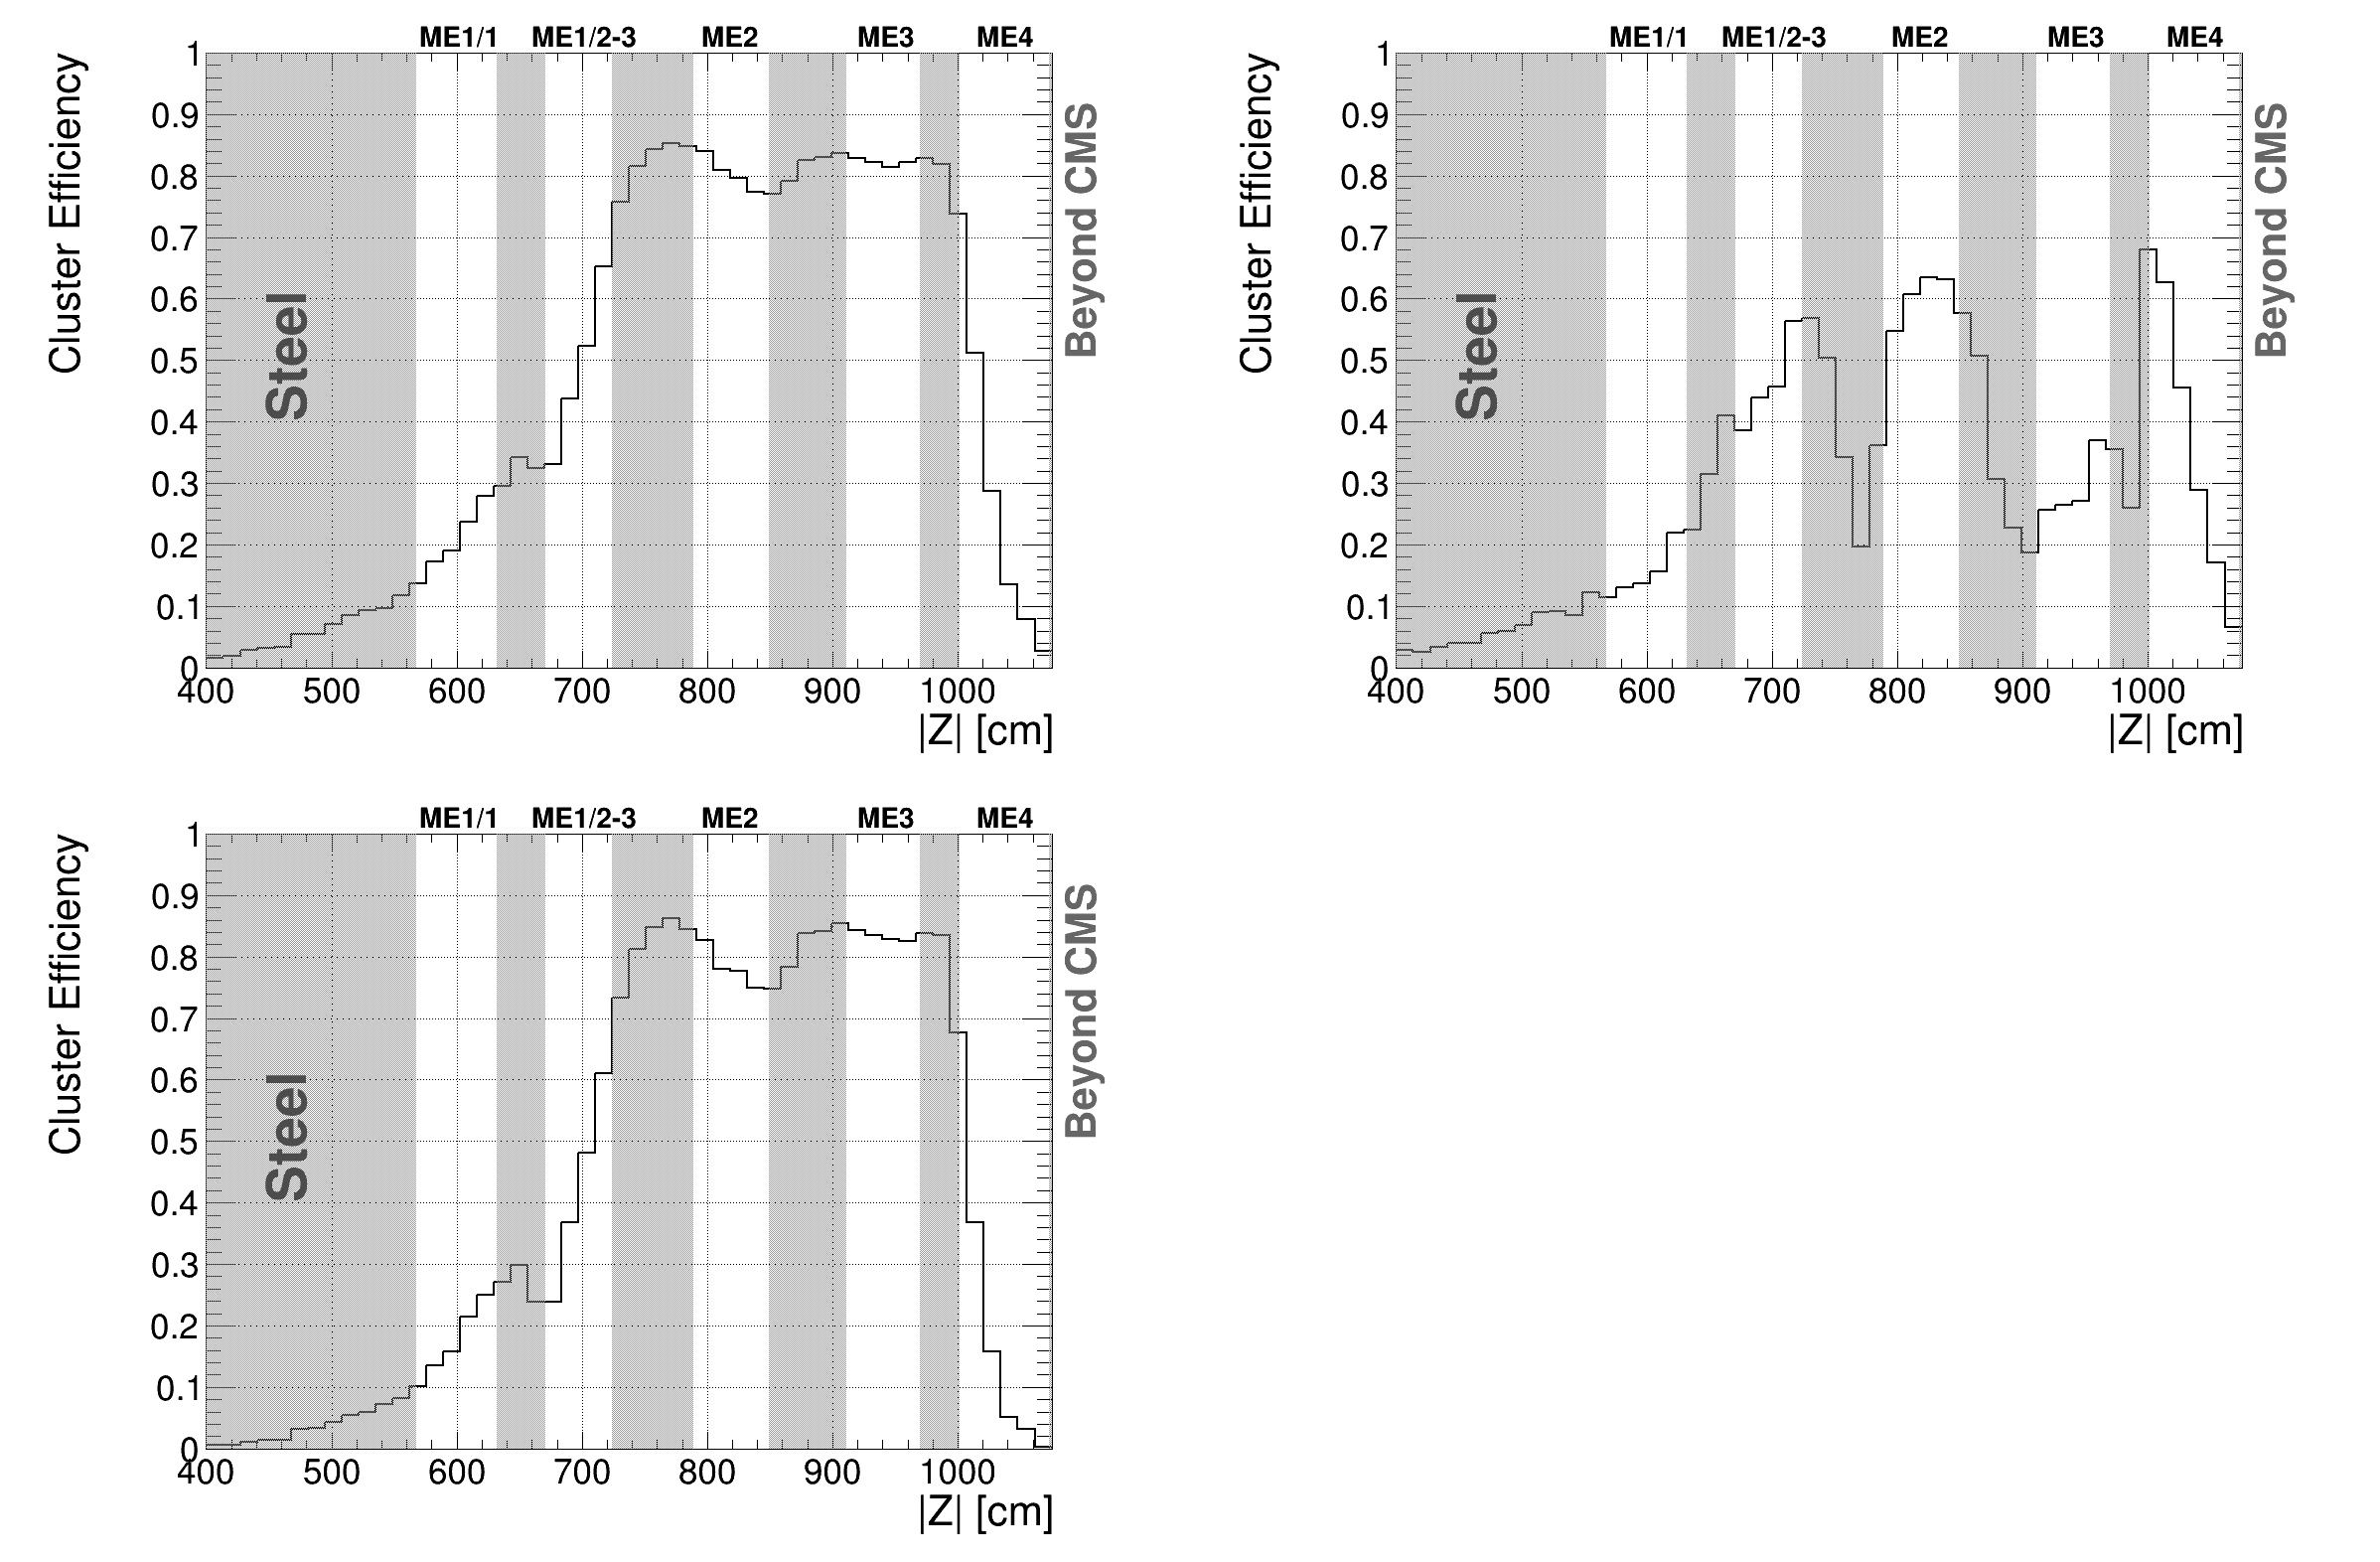

In [21]:
if data_type == 'MC':
    rdfs_num = [rdf_all_ec, rdf_bkg_ec, rdf_sig_ec]
    rdfs_den = [rdf_all_e_m, rdf_bkg_e_m, rdf_sig_e_m]

    c = canvas('c', 2, 2)
    leg = rt.TLegend(0.2,0.72,0.4,0.91)
    leg.SetTextSize(0.04)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    leg.SetFillStyle(0)
    vcut, vgen = 'RechitCluster_match_gLLP_decay_abs_', 'gLLP_decay_vertex_abs_'

    lat.SetTextAlign(33)

    bins = [50, 400, 1075]
    model_z = ('', '|Z| Decay Efficiency;|Z| [cm];Cluster Efficiency', *bins)
    ymax = 0
    ymin = 10000
    for i, (rdfn, rdfd) in enumerate(zip(rdfs_num, rdfs_den)):
        rdfn = apply_vertex_cut(rdfn)
        hh_eff_n = rdfn.Histo1D(model_z, 'csc' + vcut + 'z')
        # hh_eff_n.Add(rdfn.Histo1D(model_z, 'dt' + vcut + 'z').GetPtr()) #! Breaks efficiency plots
        hh_eff_d = rdfd.Histo1D(model_z, vgen + 'z')

        hh_eff_n.Divide(hh_eff_d.GetPtr())
        hh_eff_n.SetMinimum(0.01)
        ymax = 1#max(ymax, hh_eff_n.GetMaximum())
        ymin = 0#min(ymin, hh_eff_n.GetMinimum())
        # hh_eff_n.SetMaximum(1)
        gc.append(hh_eff_n)

    titles = ['All Events', 'Size < 100, "background"', '100 < Size, "signal"']
    for i, (hh, tt) in enumerate(zip(gc[-i-1:], titles)):
        c.cd(i + 1).SetGrid()
        c.cd(i + 1).SetRightMargin(0.1)
        hh.SetMaximum(1)#ymax * 1.03)
        hh.SetMinimum(0)#ymin)
        hh.Draw('same')

        boxes = []

        xmin, xmax = bins[1], bins[2]
        boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
        boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
        boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
        boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
        boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
        boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
        for b in boxes:
            b.SetFillColor(15)
            b.SetFillStyle(3001)
            b.Draw('same')


        l = rt.TLatex()
        l.SetTextSize(0.08)
        l.SetTextColor(12)
        l.SetTextAngle(90)
        l.DrawLatex(xmin+80, ymax*0.4, "Steel")

        l2 = rt.TLatex()
        l2.SetTextSize(0.06)
        l2.SetTextColor(13)
        l2.SetTextAngle(90)
        l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
        text = rt.TLatex()
        text.SetTextSize(0.04)
        text.DrawLatex(570, ymax*1.01, "ME1/1")
        text.DrawLatex(660, ymax*1.01, "ME1/2-3")
        text.DrawLatex(795, ymax*1.01, "ME2")
        text.DrawLatex(920, ymax*1.01, "ME3")
        text.DrawLatex(1015, ymax*1.01, "ME4")

        gc.extend(boxes + steel)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


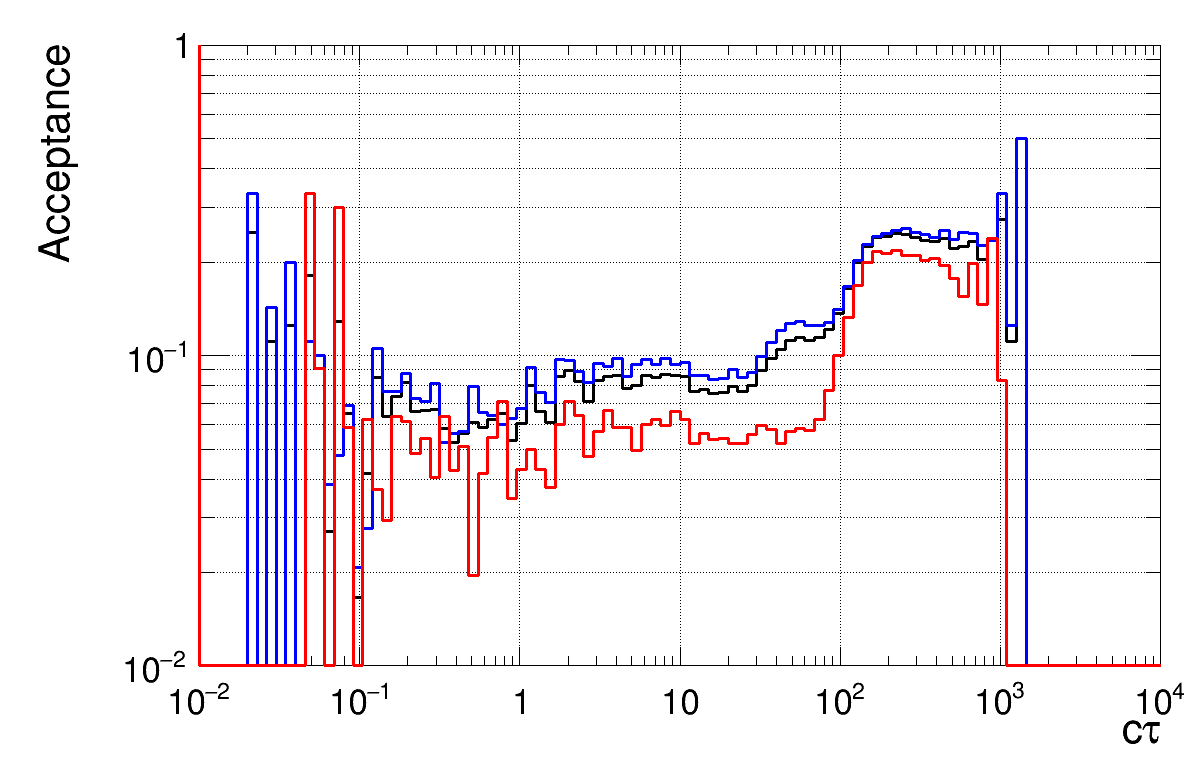

In [44]:
if data_type == 'MC':
    rdfs_num = [rdf_all_ec, rdf_sig_ec, rdf_bkg_ec]
    rdfs_den = [rdf_all_m, rdf_sig_m, rdf_bkg_m]
    colors = [rt.kBlack, rt.kBlue, rt.kRed]

    c = canvas('c')
    leg = rt.TLegend(0.2,0.72,0.4,0.91)
    leg.SetTextSize(0.04)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    leg.SetFillStyle(0)

    lat.SetTextAlign(33)

    nb = 100
    model = ('', ';c#tau;Acceptance', nb, np.logspace(-2, 4, nb+1))
    titles = ['All Events', 'Size < 100, "background"', '100 < Size, "signal"']
    for i, (rdfn, rdfd, color, title) in enumerate(zip(rdfs_num, rdfs_den, colors, titles)):
        c.cd(i + 1).SetGrid()
        c.cd(i + 1).SetLogx()
        c.cd(i + 1).SetLogy()
        hh_eff_n = rdfn.Histo1D(model, 'gLLP_ctau')
        hh_eff_d = rdfd.Histo1D(model, 'gLLP_ctau')
        hh_eff_n.Divide(hh_eff_d.GetPtr())

        hh_eff_n.SetLineColor(color)
        hh_eff_n.SetLineWidth(3)
        hh_eff_n.SetMinimum(1e-2)
        hh_eff_n.SetMaximum(1)
        
        hh_eff_n.Draw('same')
        gc.append(hh_eff_n)



bbbb_MH-125_MS-15



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


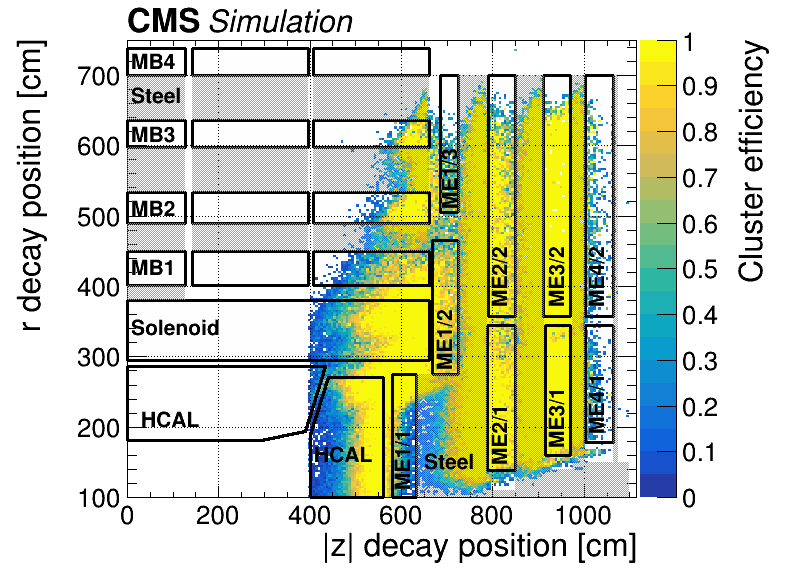

In [7]:

#############################################################################################################

# rt.gStyle.SetPaintTextFormat("6.3f")

import uproot
import awkward as ak

samples = [
#     'STodd_ms3p0',
#     'SToEE_ms0p4',
#     'SToGammaGamma_ms0p4',
#     'SToKPlusKMinus_ms1p5',
#     'SToK0K0_ms1p5',
#     'SToPi0Pi0_ms0p4',
#     'SToPi0Pi0_ms1p0',
#     'SToPiPlusPiMinus_ms0p4',
#     'SToPiPlusPiMinus_ms1p0',

#     'dddd_MH-125_MS-15',
    'bbbb_MH-125_MS-15',
#     'dddd_MH-125_MS-55',
    
#     'bbbb_MH-125_MS-15',
#     'bbbb_MH-125_MS-40',
#     'bbbb_MH-125_MS-55',
    
#     '4Tau_MH-125_MS-7',
#     '4Tau_MH-125_MS-15',
#     '4Tau_MH-125_MS-40',
#     '4Tau_MH-125_MS-55',
#     'dddd_MH-125_MS-7',

]

r_csc = {}
r_dt = {}
z_csc = {}
z_dt = {}
    
llp_r = {}
llp_z = {}
weight_llp = {}
decay = 'bbbb'

# for m in [ '15', '40','55']:
for sample in samples:
    m = sample

    
    r_csc[m] = []
    r_dt[m] = []
    z_csc[m] = []
    z_dt[m] = []
    llp_r[m] = []
    llp_z[m] =[]
    weight_llp[m] = []
    print(m)
#     if 'EE' not in sample:continue
    # analyzer_version = "/v162/"
    # if 'MH' in sample:
        
    #     path = "/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/"+analyzer_version+"normalized/"
    #     root_dir =uproot.open(path+"ggH_HToSSTo"+sample+".root")

    # else: 
    #     path = "/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/"+analyzer_version+"normalized/"
    #     root_dir =uproot.open(path+"ggH_HToSS_"+sample+".root")
    
    root_dir =uproot.open(fpath)#path+"ggH_HToSS_"+sample+".root")


    T = root_dir['MuonSystem']
    
    sel_jet = np.logical_and(T['jetPt'].array() > 30, np.abs(T['jetEta'].array()) < 2.4 )
    sel_jet = np.logical_and(T['jetTightPassId'].array(), sel_jet)
    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()

    
    sel_dt = np.logical_and(T['gLLP_decay_vertex_r'].array()>200, T['gLLP_decay_vertex_r'].array()<800)
    sel_dt = np.logical_and(sel_dt, np.abs(T['gLLP_decay_vertex_z'].array())<700)

    sel_csc = np.logical_and(np.abs(T['gLLP_eta'].array())<3, np.abs(T['gLLP_decay_vertex_z'].array())<1200)
    sel_csc = np.logical_and(sel_csc, np.abs(T['gLLP_decay_vertex_z'].array())>400)
    
    sel_csc = np.logical_and(sel_csc, T['gLLP_decay_vertex_r'].array()<800)
    sel_llp = np.logical_or(sel_dt,sel_csc)

    sel_ev = np.sum(sel_llp,axis = 1) == 1

#     sel_ev   = np.logical_and(sel_ev ,T['METNoMuTrigger'].array())
#     sel_ev = np.logical_and(sel_ev ,T['metEENoise'].array() >= 200)
    # sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
    sel_ev = np.logical_and(sel_ev , np.sum(sel_jet, axis=1)>=1)
#     sel_ev = np.logical_and(sel_ev , T['Flag2_all'].array())
    sel_llp = np.logical_or(sel_dt,sel_csc)[sel_ev]

    llp_r[m] += list(np.abs(T['gLLP_decay_vertex_r'].array())[sel_ev][sel_llp])
    llp_z[m] += list(T['gLLP_decay_vertex_z'].array()[sel_ev][sel_llp])
    # weight_llp[m] += list((T['gHiggsPt'].array()*T['weight'].array()*T['pileupWeight'].array()*T['metSF'].array())[sel_ev])
    
    cluster_index = ''

    ########### SELECTION: CLUSTERS ############
    sel_csccluster = T['cscRechitCluster'+cluster_index+'_match_gLLP'].array()
    sel_csccluster = np.logical_and(sel_csccluster, T['cscRechitCluster'+cluster_index+'_match_gLLP_decay_r'].array()<800)
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T['cscRechitCluster'+cluster_index+'_match_gLLP_decay_z'].array())<1200)
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T['cscRechitCluster'+cluster_index+'_match_gLLP_decay_z'].array())>400)

    sel_dtcluster = T['dtRechitCluster'+cluster_index+'_match_gLLP'].array()
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T['dtRechitCluster'+cluster_index+'_match_gLLP_decay_z'].array())<700)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T['dtRechitCluster'+cluster_index+'_match_gLLP_decay_r'].array())<800)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T['dtRechitCluster'+cluster_index+'_match_gLLP_decay_r'].array())>200)

    # sel_ev = np.logical_and(sel_ev,sel_csccluster.sum()+sel_dtcluster.sum()==1)
    sel_ev = np.logical_and(sel_ev,(np.sum(sel_csccluster,axis=1)+np.sum(sel_dtcluster,axis=1))==1)

    r_csc[m] += list(ak.flatten(np.abs(T['cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'].array())[sel_csccluster][sel_ev]))
    z_csc[m] += list(ak.flatten(T['cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'].array()[sel_csccluster][sel_ev]))
    r_dt[m] += list(ak.flatten(np.abs(T['dtRechitCluster' + cluster_index + '_match_gLLP_decay_r'].array())[sel_dtcluster][sel_ev]))
    z_dt[m] += list(ak.flatten(T['dtRechitCluster' + cluster_index + '_match_gLLP_decay_z'].array()[sel_dtcluster][sel_ev]))

for i, m in enumerate(samples):
#     if not 'K0' in m:continue
    c = rt.TCanvas('c','c', 800, 600)
    bins = [14, 400+15, 15+1100, 13,100,750]#100-700, CSC analysis

#     bins = [30, -1115, 15+1100, 30,0,750]#100-700

    bins = [200, 0, 15+1100, 200,100,750]#100-700
#     bins = [400, -1115, 15+1100, 200,100,750]#100-700


    title = ['r decay position [cm]', '|z| decay position [cm]']
    if bins[1]<0:
        hm = create_TH2D(np.column_stack((z_csc[m]+z_dt[m],r_csc[m]+r_dt[m])), 'hm1', axis_title = [title[1], title[0], 'Cluster efficiency'], binning=bins)
        hb = create_TH2D(np.column_stack((llp_z[m],llp_r[m])), 'hb1', axis_title = [title[1], title[0],'Cluster efficiency'], binning=bins)
    else:
        hm = create_TH2D(np.abs(np.column_stack((z_csc[m]+z_dt[m],r_csc[m]+r_dt[m]))), 'hm1', axis_title = [title[1], title[0], 'Cluster efficiency'], binning=bins)
        hb = create_TH2D(np.abs(np.column_stack((llp_z[m],llp_r[m]))), 'hb1', axis_title = [title[1], title[0],'Cluster efficiency'], binning=bins)

    pEff1 = rt.TEfficiency(hm,hb)
    hist = hm.Clone()
    
    for y in range(1, hm.GetYaxis().GetNbins()+1):
            for x in range(1, hm.GetXaxis().GetNbins()+1):
                global_bin = pEff1.GetGlobalBin(x,y)
                if pEff1.GetEfficiency(global_bin)<0.01 and pEff1.GetEfficiency(global_bin)>0:
#                     print(hm.GetXaxis().GetBinCenter(x), hm.GetYaxis().GetBinCenter(y), pEff1.GetEfficiency(global_bin))
                    pEff1.SetPassedEvents(global_bin, 0)
#                 elif pEff1.GetEfficiency(global_bin)>0:
#                     if hm.GetXaxis().GetBinCenter(x)>850 and hm.GetXaxis().GetBinCenter(x)<900:
#                         print(hm.GetXaxis().GetBinCenter(x), hm.GetYaxis().GetBinCenter(y), round(pEff1.GetEfficiency(global_bin),2), round(pEff1.GetEfficiencyErrorUp(global_bin),2))


                if x==hm.GetXaxis().GetNbins():pEff1.SetPassedEvents(global_bin, 0)
                hist.SetBinContent(x,y,pEff1.GetEfficiency(global_bin))

#     pEff1.Draw('colz')
    hist.SetMaximum(1.0)
    hist.Draw('colz')

    c.SetTopMargin(0.07)


    c.SetRightMargin(0.2)
    c.Draw()
    
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = 1
    CMS_lumi.extraText   = "Simulation"
#     CMS_lumi.extraText   = "Simulation Preliminary"


    if( iPos==0 ): CMS_lumi.relPosX = 0.15
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 0, iPos)

    boxes = []
    # DT
    boxes.append(rt.TBox(max(bins[1],-661),402,126.8,449)) #MB1, wheel0
    boxes.append(rt.TBox(141.8,402,395.4,449)) #MB1, wheel1
    boxes.append(rt.TBox(407.4,402,661,449)) #MB1, wheel2

    boxes.append(rt.TBox(max(bins[1],-661),490,126.8,533)) #MB2
    boxes.append(rt.TBox(141.8,490,395.4,533)) #MB2
    boxes.append(rt.TBox(407.4,490,661,533)) #MB2

    boxes.append(rt.TBox(max(bins[1],-661),597,126.8,636)) #MB3
    boxes.append(rt.TBox(141.8,597,395.4,636)) #MB3
    boxes.append(rt.TBox(407.4,597,661,636)) #MB3
    
    boxes.append(rt.TBox(max(bins[1],-661),700,126.8,738)) #MB4
    boxes.append(rt.TBox(141.8,700,395.4,738)) #MB4
    boxes.append(rt.TBox(407.4,700,661,738)) #MB4

    boxes.append(rt.TBox(max(bins[1],-661),295,661,380)) #solenoid

    # +z mirror of CSC
    boxes.append(rt.TBox(791,357,850,700)) #ME2/2
    boxes.append(rt.TBox(911,357,970,700)) #ME3/2
    boxes.append(rt.TBox(1002,357,1063,700)) #ME4/2

    boxes.append(rt.TBox(789,139,850,345)) #ME2/1
    boxes.append(rt.TBox(915,160,970,345)) #ME3/1
    boxes.append(rt.TBox(1002,178,1063,345)) #ME4/1

    boxes.append(rt.TBox(580,100,632,275)) #ME1/1
    boxes.append(rt.TBox(668,275,724,465)) #ME1/2
    boxes.append(rt.TBox(686,505,724,700)) #ME1/3
    boxes.append(create_TGraph([400.5,560,560,440,400.5,400.5],[100.5,100.5,270,270,190,100.5])) #hcal endcap
    boxes.append(create_TGraph([433.2, 0.0,0.0,293.5, 390.5, 433.2],[286.4,286.4,181.1,181.1,194.1, 286.4])) #hcal barrel

    
    # -z mirror of CSC
    if bins[1]<0:
        boxes.append(rt.TBox(-791,357,-850,700)) #ME2/2
        boxes.append(rt.TBox(-911,357,-970,700)) #ME3/2
        boxes.append(rt.TBox(-1002,357,-1063,700)) #ME4/2

        boxes.append(rt.TBox(-789,139,-850,345)) #ME2/1
        boxes.append(rt.TBox(-915,160,-970,345)) #ME3/1
        boxes.append(rt.TBox(-1002,178,-1063,345)) #ME4/1

        boxes.append(rt.TBox(-580,100,-632,275)) #ME1/1
        boxes.append(rt.TBox(-668,275,-724,465)) #ME1/2
        boxes.append(rt.TBox(-686,505,-724,700)) #ME1/3
        boxes.append(create_TGraph([-400.5,-560,-560,-440,-400.5,-400.5],[100.5,100.5,270,270,190,100.5])) #hcal
        boxes.append(create_TGraph([-433.2, 0.0,0.0,-293.5, -390.5, -433.2],[286.4,286.4,181.1,181.1,194.1, 286.4])) #hcal barrel

    for b in boxes:
        b.SetFillColorAlpha(15,0)
        b.SetLineWidth(3)
        b.SetLineColor(1)
    #     b.SetFillStyle(3001)
        b.Draw('l same')

    steel = []
    steel.append(rt.TBox(max(bins[1],-661),380,126.8,402)) #MB1, wheel0


    steel.append(rt.TBox(max(bins[1],-661),449,126.8,490)) #MB1, wheel0
    steel.append(rt.TBox(141.8,449,395.4,490)) #MB1, wheel1
    steel.append(rt.TBox(407.4,449,661,490)) #MB1, wheel2
    
    steel.append(rt.TBox(max(bins[1],-661),533,126.8,597)) #MB2
    steel.append(rt.TBox(141.8,533,395.4,597)) #MB2
    steel.append(rt.TBox(407.4,533,661,597)) #MB2
    
    steel.append(rt.TBox(max(bins[1],-661),636,126.8,700)) #MB3
    steel.append(rt.TBox(141.8,636,395.4,700)) #MB3
    steel.append(rt.TBox(407.4,636,661,700)) #MB3
    
    x=[633,633, 1100, 1100, 1075, 1075, 1063, 1063,1002,1002,975,975,912,912,849,849,789,789,724,724, 633]
    y=[275, 100, 100, 150, 150, 700,700,150,150,700,700,140,140,700,700,110,110,700,700,275,275]
    steel.append(create_TGraph(x,y)) 



    for b in steel:
#         b.SetFillColorAlpha(15,0.5)
        b.SetFillStyle(3001)
        b.SetFillColorAlpha(15,0.9)
        b.Draw('fsame')

    
    text = rt.TLatex()
    text.SetTextSize(0.04)


    

    text.DrawLatex(bins[1]+10, 415, "MB1")
    text.DrawLatex(bins[1]+10, 500, "MB2")
    text.DrawLatex(bins[1]+10, 605, "MB3")
    text.DrawLatex(bins[1]+10, 708, "MB4")

    text.DrawLatex(650, 140, "Steel")
    text.DrawLatex(bins[1]+10,660, "Steel")
    text.DrawLatex(bins[1]+10, 330, "Solenoid")
    text.DrawLatex(bins[1]+30, 200, "HCAL")
    text.DrawLatex(410, 150, "HCAL")

    text.SetTextAngle(90)
    ring2_r = 370
    text.DrawLatex(620, 110, "ME1/1")
    text.DrawLatex(712, 280, "ME1/2")
    text.DrawLatex(722, 510, "ME1/3")

    text.DrawLatex(832, 145, "ME2/1")
    text.DrawLatex(832, ring2_r, "ME2/2")

    text.DrawLatex(957, 170, "ME3/1")
    text.DrawLatex(957, ring2_r, "ME3/2")

    text.DrawLatex(1045, 190, "ME4/1")
    text.DrawLatex(1045, ring2_r, "ME4/2")


    # outDir = "/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/"
    # print(m)
    # if not os.path.isdir(outDir):os.makedirs(outDir)
    # if CMS_lumi.extraText == 'Simulation Preliminary':
    #     c.SaveAs(outDir+"2D_sig_eff_"+m+"_pas.C")
    #     c.SaveAs(outDir+"2D_sig_eff_"+m+"_pas.pdf")
    #     c.SaveAs(outDir+"2D_sig_eff_"+m+"_pas.png")
    # else:
    #     c.SaveAs(outDir+"2D_sig_eff_"+m+".C")
    #     c.SaveAs(outDir+"2D_sig_eff_"+m+".png")
    #     c.SaveAs(outDir+"2D_sig_eff_"+m+".pdf")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).


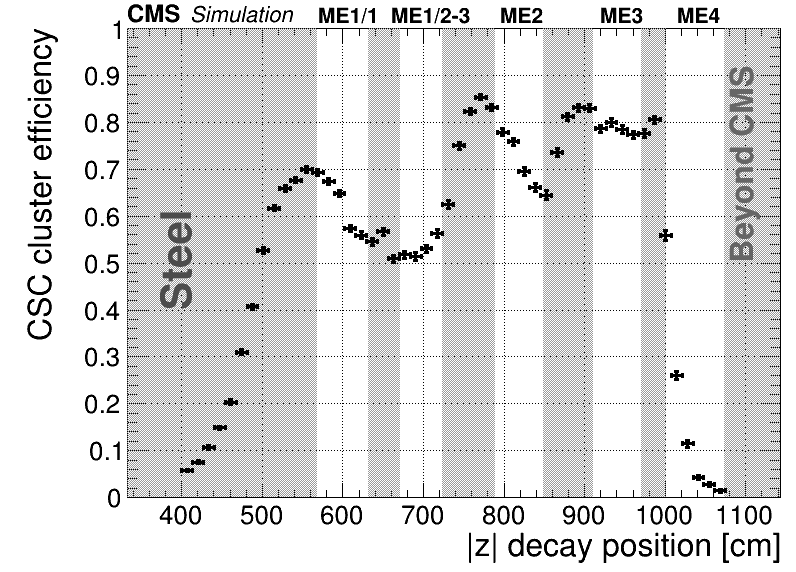

In [8]:
bins = [50, 400, 1075]
xaxis_title = '|z| decay position [cm]'

leg = rt.TLegend(0.2,0.72,0.4,0.91)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg.SetFillStyle(0)

c = rt.TCanvas('c','c', 800, 600)
pEff= {}
for i,m in enumerate(samples):
    hm = create_TH1D(np.abs(z_csc[m]), 'hb1', axis_title = [xaxis_title,'CSC cluster efficiency'], binning=bins)
    hb = create_TH1D(np.abs(llp_z[m]), 'hb1', axis_title = [xaxis_title,'CSC cluster efficiency'], binning=bins)
    pEff[m] = rt.TEfficiency(hm,hb)
    pEff[m].SetLineColor(std_color_list[i])
    pEff[m].SetLineWidth(3)

    if 'EE' in m:leg.AddEntry(pEff[m], 'S #rightarrow e^{+}e^{-}','lpe3')
    elif 'dd' in m:leg.AddEntry(pEff[m], 'S #rightarrow d#bar{d}','LPE4')
    else:leg.AddEntry(pEff[m], 'S #rightarrow #tau^{+}#tau^{-}','LPE5')
        
        
    pEff[m].Draw('' if i == 0 else 'Psame')
c.Draw()
    
# leg.Draw()
pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetYaxis().SetTitleOffset(0.0);



# ymax = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetMaximum()
# ymin = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetMinimum()
xmin = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
xmax = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()
ymax = 1
ymin = 0
pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().SetMaximum(ymax)
pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().SetMinimum(ymin)



boxes = []

boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
for b in boxes:
    b.SetFillColor(15)
    b.SetFillStyle(3001)
    b.Draw('same')


l = rt.TLatex()
l.SetTextSize(0.08)
l.SetTextColor(12)
l.SetTextAngle(90)
l.DrawLatex(xmin+80, ymax*0.4, "Steel")

l2 = rt.TLatex()
l2.SetTextSize(0.06)
l2.SetTextColor(13)
l2.SetTextAngle(90)
l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
text = rt.TLatex()
text.SetTextSize(0.04)
text.DrawLatex(570, ymax*1.01, "ME1/1")
text.DrawLatex(660, ymax*1.01, "ME1/2-3")
text.DrawLatex(795, ymax*1.01, "ME2")
text.DrawLatex(920, ymax*1.01, "ME3")
text.DrawLatex(1015, ymax*1.01, "ME4")

CMS_lumi.cmsText     = "CMS"
CMS_lumi.relPosX = 0.09
CMS_lumi.relPosY = 0.0
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation"
#         CMS_lumi.extraText   = "Simulation Supplementary"


CMS_lumi.CMS_lumi(c, 0, 0)



for k,v in pEff.items():pEff[k].Draw('same')
# leg.Draw()

c.Draw()


# outDir = "/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/"
# if not os.path.isdir(outDir):os.makedirs(outDir)
# if CMS_lumi.extraText == 'Simulation Preliminary':
#     c.SaveAs(outDir+"csc_1D_sig_eff_pas.C")
#     c.SaveAs(outDir+"csc_1D_sig_eff_pas.pdf")
#     c.SaveAs(outDir+"csc_1D_sig_eff_pas.png")
# else:
#     c.SaveAs(outDir+"csc_1D_sig_eff.C")
#     c.SaveAs(outDir+"csc_1D_sig_eff.png")
#     c.SaveAs(outDir+"csc_1D_sig_eff.pdf")

In [ ]:
# decay = 'dddd'
# mass = [ '15' ]
# ctaus  = ['1000']

# acceptance = {}
# sel_ev = {}
# accep_met = {}

# sel_ev_cross = {}
# sel_ev_csc2 = {}
# sel_ev_dt2 = {}
# sel_ev_csc1 = {}
# sel_ev_dt1 = {}

# acceptance_dt1 = {}
# acceptance_csc1 = {}
# acceptance_dt2 = {}
# acceptance_csc2 = {}
# acceptance_cross = {}
# acceptance_2tag = {}
# accep_met_dt1 = {}
# accep_met_csc1 = {}
# accep_met_dt2 = {}
# accep_met_csc2 = {}
# accep_met_cross = {}
# accep_met_2tag = {}
# weight = {}
# higgsPtWeight = {}


# for k, T in tree.items():
# #     sel_dtcluster = T.array('dtRechitCluster_match_gLLP')
#     sel_dt = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')) < 661, np.abs(T.array('gLLP_decay_vertex_r')) > 380)
#     sel_dt = np.logical_and(sel_dt, np.abs(T.array('gLLP_decay_vertex_r')) <738 )
        
        
#     sel_csc = np.logical_and(np.abs(T.array('gLLP_eta') < 2.4), np.abs(T.array('gLLP_decay_vertex_r')) < 695.5)
#     sel_csc = np.logical_and(sel_csc, np.abs(T.array('gLLP_decay_vertex_z')) < 1100 )
#     sel_csc = np.logical_and(sel_csc, np.abs(T.array('gLLP_decay_vertex_z')) > 661 )

    
#     me11 = np.logical_and(np.abs(T.array('gLLP_eta') < 2.4), np.abs(T.array('gLLP_decay_vertex_r')) < 270)
#     me11 = np.logical_and(me11, np.abs(T.array('gLLP_decay_vertex_z')) < 661 )
#     me11 = np.logical_and(me11, np.abs(T.array('gLLP_decay_vertex_z')) > 500 )
    
#     sel_csc = np.logical_or(sel_csc, me11) # definition to make sure no overlap
# #     sel_csc = T.array('gLLP_csc') # definition for EXO-20-015

# #     print(k, np.sum(np.logical_and(sel_csc,sel_dt).sum()))
#     sel_ev_cross[k] = np.logical_and(np.sum(sel_csc,axis = 1) == 1, np.sum(sel_dt,axis = 1)==1)
#     sel_ev_csc2[k] = np.sum(sel_csc,axis = 1) == 2
#     sel_ev_dt2[k] =np.sum(sel_dt,axis = 1) == 2
#     sel_ev_csc1[k] = np.sum(sel_csc,axis = 1) >= 1
#     sel_ev_dt1[k] =np.sum(sel_dt,axis = 1) >= 1
# # #     print(k, np.count_nonzero(np.sum(np.logical_and(sel_dt, sel_csc))))
# #     if np.count_nonzero(sel_ev_dt2[k])>0:
# #         print(k, np.count_nonzero(np.logical_and(sel_ev_dt2[k], T.array('nDtRechitClusters')>=2))/np.count_nonzero(sel_ev_dt2[k]))
# #         print(k, np.count_nonzero( T.array('nDtRechitClusters')>=2)/len(sel_ev_dt2[k]))

    
#     acceptance_dt1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_dt1[k]])/np.sum(T.array('weight'))
#     acceptance_csc1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc1[k]])/np.sum(T.array('weight'))
#     acceptance_dt2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_dt2[k]])/np.sum(T.array('weight'))
#     acceptance_csc2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc2[k]])/np.sum(T.array('weight'))
#     acceptance_cross[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_cross[k]])/np.sum(T.array('weight'))
#     acceptance_2tag[k] = acceptance_dt2[k] + acceptance_csc2[k] + acceptance_cross[k]


    
    
#     sel_ev[k] = np.logical_and(T.array('metEENoise')>=200 ,T.array('METNoMuTrigger'))

    
#     accep_met_dt1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_dt1[k])])/np.sum(T.array('weight'))
#     accep_met_csc1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_csc1[k])])/np.sum(T.array('weight'))
#     accep_met_dt2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_dt2[k])])/np.sum(T.array('weight'))
#     accep_met_csc2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_csc2[k])])/np.sum(T.array('weight'))
#     accep_met_cross[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_cross[k])])/np.sum(T.array('weight'))
    
#     accep_met_2tag[k] = accep_met_dt2[k] + accep_met_csc2[k] + accep_met_cross[k]


# #     print(k,'\t', acceptance_csc1[k],'\t', accep_met_csc1[k], np.sum(T.array('weight')))
